In [1]:
import syft as sy
sy.requires(">=0.8,<0.8.1")
from syft.client.api import NodeView

/home/teo/anaconda3/envs/PySyft/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/teo


✅ The installed version of syft==0.8.0b6 matches the requirement >=0.8b0


In [2]:
node = sy.orchestra.launch(name="test-domain-1", port=8080, dev_mode=True)

SQLite Store Path:
!open file:///tmp/7bca415d13ed1ec841f0d0aede098dbb.sqlite

> Starting Worker: test-domain-1 - 7bca415d13ed1ec841f0d0aede098dbb - NodeType.DOMAIN - [<class 'syft.core.node.new.user_service.UserService'>, <class 'syft.core.node.new.metadata_service.MetadataService'>, <class 'syft.core.node.new.action_service.ActionService'>, <class 'syft.core.node.new.test_service.TestService'>, <class 'syft.core.node.new.dataset_service.DatasetService'>, <class 'syft.core.node.new.user_code_service.UserCodeService'>, <class 'syft.core.node.new.request_service.RequestService'>, <class 'syft.core.node.new.data_subject_service.DataSubjectService'>, <class 'syft.core.node.new.network_service.NetworkService'>, <class 'syft.core.node.new.policy_service.PolicyService'>, <class 'syft.core.node.new.message_service.MessageService'>, <class 'syft.core.node.new.project_service.ProjectService'>, <class 'syft.core.node.new.data_subject_member_service.DataSubjectMemberService'>]


In [3]:
guest_domain_client = node.client

In [4]:
guest_credentials = guest_domain_client.credentials
guest_credentials

<SigningKey for: 2156695f5ced150c20266b13b8274427646e06f13ce38d5f8cb2b2943082205f>

In [5]:
guest_domain_client.register(name="Jane Doe", email="jane@caltech.edu", password="abc123", institution="Caltech", website="https://www.caltech.edu/")

<class 'syft.core.node.new.response.SyftSuccess'>: jane@caltech.edu User successfully registered !!!

In [6]:
guest_domain_client.login(email="jane@caltech.edu", password="abc123")

<SyftClient - test-domain-1 <7bca415d13ed1ec841f0d0aede098dbb>: PythonConnection>

In [7]:
assert guest_domain_client.credentials != guest_credentials

In [8]:
results = guest_domain_client.api.services.dataset.get_all()
results

,type,id,name,url
0,syft.core.node.new.dataset.Dataset,3657f3aa5316422698f606fa3e902356,Canada Trade Value,https://github.com/OpenMined/datasets/tree/mai...


In [9]:
assert len(results) == 1

In [10]:
dataset = results[-1]

In [11]:
dataset

```python
Syft Dataset: Canada Trade Value
Assets:
	canada_trade_flow: all the datas
Citation: Person, place or thing
URL: https://github.com/OpenMined/datasets/tree/main/trade_flow
Description: Canada Trade Data

```

In [12]:
mock = dataset.assets[0].mock
mock

,Classification,Year,Period,Period Desc.,Aggregate Level,Is Leaf Code,Trade Flow Code,Trade Flow,Reporter Code,Reporter,...,Partner,Partner ISO,Commodity Code,Commodity,Qty Unit Code,Qty Unit,Qty,Netweight (kg),Trade Value (US$),Flag
10,HS,2021,202102,February 2021,2,0,1,Imports,124,Canada,...,Bangladesh,NaN,19,"Preparations of cereals, flour, starch or milk...",0,NaN,NaN,0.0,227222,0
11,HS,2021,202102,February 2021,2,0,1,Imports,124,Canada,...,Haiti,NaN,19,"Preparations of cereals, flour, starch or milk...",0,NaN,NaN,0.0,14748,0
12,HS,2021,202102,February 2021,2,0,1,Imports,124,Canada,...,Guatemala,NaN,19,"Preparations of cereals, flour, starch or milk...",0,NaN,NaN,0.0,1314,0
13,HS,2021,202102,February 2021,2,0,1,Imports,124,Canada,...,Iraq,NaN,19,"Preparations of cereals, flour, starch or milk...",0,NaN,NaN,0.0,1825,0
14,HS,2021,202102,February 2021,2,0,1,Imports,124,Canada,...,Israel,NaN,19,"Preparations of cereals, flour, starch or milk...",0,NaN,NaN,0.0,1063627,0
15,HS,2021,202102,February 2021,2,0,1,Imports,124,Canada,...,Italy,NaN,19,"Preparations of cereals, flour, starch or milk...",0,NaN,NaN,0.0,8359327,0
16,HS,2021,202102,February 2021,2,0,1,Imports,124,Canada,...,Jordan,NaN,19,"Preparations of cereals, flour, starch or milk...",0,NaN,NaN,0.0,16858,0
17,HS,2021,202102,February 2021,2,0,1,Imports,124,Canada,...,Rep. of Moldova,NaN,19,"Preparations of cereals, flour, starch or milk...",0,NaN,NaN,0.0,29897,0
18,HS,2021,202102,February 2021,2,0,1,Imports,124,Canada,...,Nigeria,NaN,19,"Preparations of cereals, flour, starch or milk...",0,NaN,NaN,0.0,22235,0
19,HS,2021,202102,February 2021,2,0,1,Imports,124,Canada,...,Slovenia,NaN,19,"Preparations of cereals, flour, starch or milk...",0,NaN,NaN,0.0,1328,0


In [13]:
mock["Trade Value (US$)"].sum()

dict_keys([typing.Any, <class 'numpy.ndarray'>, <class 'numpy.bool_'>, <class 'numpy.int8'>, <class 'numpy.int16'>, <class 'numpy.int32'>, <class 'numpy.int64'>, <class 'numpy.uint8'>, <class 'numpy.uint16'>, <class 'numpy.uint32'>, <class 'numpy.uint64'>, <class 'numpy.float16'>, <class 'numpy.float32'>, <class 'numpy.float64'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.series.Series'>])
dict_keys([typing.Any, <class 'numpy.ndarray'>, <class 'numpy.bool_'>, <class 'numpy.int8'>, <class 'numpy.int16'>, <class 'numpy.int32'>, <class 'numpy.int64'>, <class 'numpy.uint8'>, <class 'numpy.uint16'>, <class 'numpy.uint32'>, <class 'numpy.uint64'>, <class 'numpy.float16'>, <class 'numpy.float32'>, <class 'numpy.float64'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.series.Series'>])


9738381

In [16]:
@sy.syft_function(input_policy=sy.ExactMatch(trade_data=mock),
                  output_policy=sy.SingleExecutionExactOutput())
def sum_trade_value_mil(trade_data):
    import numpy as np
    np.random.set_state(0)
    import pandas as pd
    from opendp.mod import enable_features
    enable_features('contrib')
    from opendp.measurements import make_base_laplace
    import matplotlib.pyplot as plt
    aggregate = 0.
    base_lap = make_base_laplace(scale=5.)
    noise = base_lap(aggregate)

    df = trade_data
    total = df["Trade Value (US$)"].sum()
    plt.scatter(list(trade_data), list(trade_data))
    
    return (float(total / 1_000_000), float(noise))

(9.738381, 33.63071423716574)

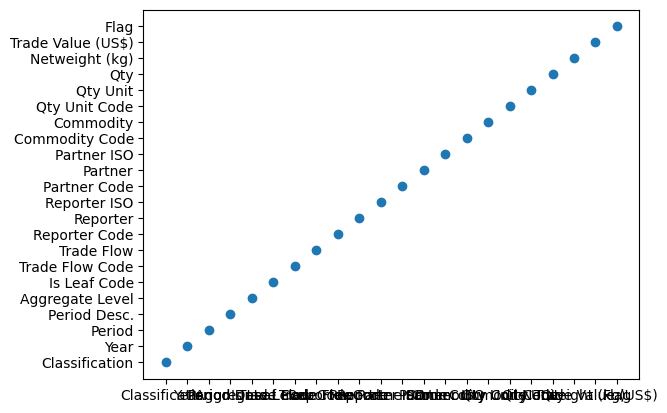

In [23]:
result = sum_trade_value_mil(trade_data=mock)
result

In [24]:
import matplotlib.pyplot as plt

figure = plt.gcf()


<Figure size 640x480 with 0 Axes>

Figure(640x480)


In [ ]:
assert result[0] == 9.738381

In [ ]:
assert isinstance(result[1], float)

In [ ]:
assert len(sum_trade_value_mil.kwargs) == 1

In [ ]:
node_view = NodeView.from_api(guest_domain_client.api)
assert node_view in sum_trade_value_mil.kwargs

In [ ]:
assert "trade_data" in sum_trade_value_mil.kwargs[node_view]

In [ ]:
assert sum_trade_value_mil.input_policy_init_kwargs[node_view]["trade_data"] == mock.id

In [ ]:
sum_trade_value_mil.code

'@sy.syft_function(input_policy=sy.ExactMatch(trade_data=mock),\n                  output_policy=sy.SingleExecutionExactOutput())\ndef sum_trade_value_mil(trade_data):\n    import pandas as pd\n    from opendp.mod import enable_features\n    enable_features(\'contrib\')\n    from opendp.measurements import make_base_laplace\n    aggregate = 0.\n    base_lap = make_base_laplace(scale=5.)\n    noise = base_lap(aggregate)\n\n    df = trade_data\n    total = df["Trade Value (US$)"].sum()\n    return (float(total / 1_000_000), float(noise))\n'

In [ ]:
guest_domain_client.api.services.code.request_code_execution(sum_trade_value_mil)

syft.core.node.new.user_code.SubmitUserCode
syft.core.node.new.user_code.UserCode
Ok(syft.core.node.new.user_code.UserCode)


```python
class Request:
  id: str = be98963702734fe9af794df73f4e5e98
  requesting_user_verify_key: str = f8a4ce61f6a4974c6412c37412bcfccbd03af581f5ba6932efefb097b6006968
  approving_user_verify_key: str = None
  request_time: str = 2023-04-11 06:46:37
  approval_time: str = None
  status: str = RequestStatus.PENDING
  node_uid: str = 7bca415d13ed1ec841f0d0aede098dbb
  request_hash: str = "3b2f4dbd8a675b9f3685624e33c986da6285af056e1f3674ae2de0716d226126"
  changes: str = [syft.core.node.new.request.UserCodeStatusChange]

```

In [ ]:
guest_domain_client.code

,type,id,status,service_func_name
0,syft.core.node.new.user_code.UserCode,1be6664aff244c5baf5aa0e44453773f,"{NodeView(node_name='test-domain-1', verify_ke...",sum_trade_value_mil


In [ ]:
assert len(guest_domain_client.api.services.code.get_all()) == 1

In [ ]:
new_project = sy.Project(name="My Cool UN Project")

In [ ]:
proj_desc = """Hi, I want to calculate the trade volume in million's with my cool code."""
new_project.set_description(proj_desc)

In [ ]:
submitted_code = guest_domain_client.code[0]

In [ ]:
submitted_code

```python
class UserCode:
  id: str = 1be6664aff244c5baf5aa0e44453773f
  node_uid: str = None
  user_verify_key: str = f8a4ce61f6a4974c6412c37412bcfccbd03af581f5ba6932efefb097b6006968
  raw_code: str = "@sy.syft_function(input_policy=sy.ExactMatch(trade_data=mock),
                  output_policy=sy.SingleExecutionExactOutput())
def sum_trade_value_mil(trade_data):
    import pandas as pd
    from opendp.mod import enable_features
    enable_features('contrib')
    from opendp.measurements import make_base_laplace
    aggregate = 0.
    base_lap = make_base_laplace(scale=5.)
    noise = base_lap(aggregate)

    df = trade_data
    total = df["Trade Value (US$)"].sum()
    return (float(total / 1_000_000), float(noise))
"
  input_policy_type: str = <class 'syft.core.node.new.policy.ExactMatch'>
  input_policy_init_kwargs: str = {NodeView(node_name='test-domain-1', verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f): {'trade_data': <UID: 62a39c70e69d446ab3e37e4b30b117d6>}}
  input_policy_state: str = b''
  output_policy_type: str = <class 'syft.core.node.new.policy.OutputPolicyExecuteOnce'>
  output_policy_init_kwargs: str = {}
  output_policy_state: str = b''
  parsed_code: str = "

def user_func_sum_trade_value_mil_f8a4ce61f6a4974c6412c37412bcfccbd03af581f5ba6932efefb097b6006968_5cd11d8bc44ba9ca10a6a7f1ce43e49dfbe8f969c6370ef5d062a6390d12a4a0(trade_data):

    def sum_trade_value_mil(trade_data):
        import pandas as pd
        from opendp.mod import enable_features
        enable_features('contrib')
        from opendp.measurements import make_base_laplace
        aggregate = 0.0
        base_lap = make_base_laplace(scale=5.0)
        noise = base_lap(aggregate)
        df = trade_data
        total = df['Trade Value (US$)'].sum()
        return (float((total / 1000000)), float(noise))
    result = sum_trade_value_mil(trade_data=trade_data)
    return result
"
  service_func_name: str = "sum_trade_value_mil"
  unique_func_name: str = "user_func_sum_trade_value_mil_f8a4ce61f6a4974c6412c37412bcfccbd03af581f5ba6932efefb097b6006968_5cd11d8bc44ba9ca10a6a7f1ce43e49dfbe8f969c6370ef5d062a6390d12a4a0"
  user_unique_func_name: str = "user_func_sum_trade_value_mil_f8a4ce61f6a4974c6412c37412bcfccbd03af581f5ba6932efefb097b6006968"
  code_hash: str = "5cd11d8bc44ba9ca10a6a7f1ce43e49dfbe8f969c6370ef5d062a6390d12a4a0"
  signature: str = (trade_data)
  status: str = {NodeView(node_name='test-domain-1', verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f): <UserCodeStatus.SUBMITTED: 'submitted'>}
  input_kwargs: str = ['trade_data']
  enclave_metadata: str = None

```

In [ ]:
new_project.add_request(obj=submitted_code, permission=sy.UserCodeStatus.EXECUTE)

In [ ]:
new_project.changes

,type,id
0,syft.core.node.new.project.ObjectPermissionChange,7dabaf2fb20d43d2b8cded320827a148


In [ ]:
new_project

```python
class ProjectSubmit:
  id: str = None
  name: str = "My Cool UN Project"
  description: str = "Hi, I want to calculate the trade volume in million's with my cool code."
  changes: str = [syft.core.node.new.project.ObjectPermissionChange]

```

In [ ]:
guest_domain_client.submit_project(new_project)

<class 'syft.core.node.new.response.SyftSuccess'>: Project Submitted

In [ ]:
guest_domain_client._api = None
_ = guest_domain_client.api

In [ ]:
result = guest_domain_client.api.services.code.sum_trade_value_mil(trade_data=mock.id)
result

<class 'syft.core.node.new.response.SyftNotReady'>: <class 'syft.core.node.new.user_code.UserCode'> Your code is waiting for approval: {NodeView(node_name='test-domain-1', verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f): <UserCodeStatus.SUBMITTED: 'submitted'>}

In [ ]:
assert isinstance(result, sy.SyftNotReady)

In [ ]:
if node.node_type.value == "python":
    node.land()